In [27]:
import bayesflow as bf
import keras

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def prior():
    mu1 = -1 + np.random.standard_normal()
    mu2 = 1 + np.random.standard_normal()
    return {"mu": np.stack([mu1, mu2])}

In [3]:
def likelihood(mu, num_obs=10):
    return {"x": mu + np.random.standard_normal((num_obs, 2))}

In [4]:
simulator = bf.make_simulator([prior, likelihood])

In [19]:
ratio_approximator = bf.approximators.RatioApproximator(
    classifier_network=bf.networks.MLP(),
    summary_network=bf.networks.DeepSet(),
    gamma=5
)

In [20]:
ratio_approximator.compile(optimizer="adam")

In [21]:
history = ratio_approximator.fit(
    epochs=10, 
    simulator=simulator,
    num_batches=1000, 
    batch_size=32, inference_variables=["mu"], 
    inference_conditions=["x"]
)

INFO:bayesflow:Building dataset from simulator instance of SequentialSimulator.
INFO:bayesflow:Using 20 data loading workers.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.5000
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.4496
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.4467
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.4440
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.4417
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.4400
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.4394
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.4388
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.4386
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.4384


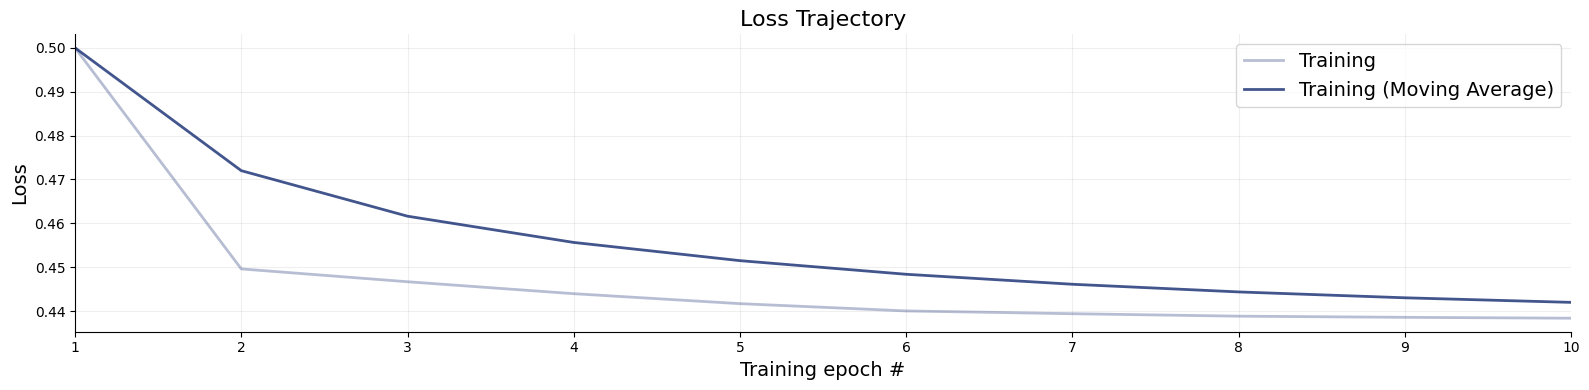

In [23]:
f = bf.diagnostics.plots.loss(history)

In [24]:
adapter = bf.approximators.RatioApproximator.build_adapter(inference_variables="mu", inference_conditions=["x"])

In [25]:
sims = simulator.sample(100)
sims = adapter(sims)
contrastive_sims = {
    "inference_variables": sims["inference_variables"][::-1],
    "inference_conditions": sims["inference_conditions"]
}

In [26]:
log_ratio_positive = keras.ops.convert_to_numpy(ratio_approximator.log_ratio(sims))
log_ratio_negative = keras.ops.convert_to_numpy(ratio_approximator.log_ratio(contrastive_sims))

<Axes: ylabel='Count'>

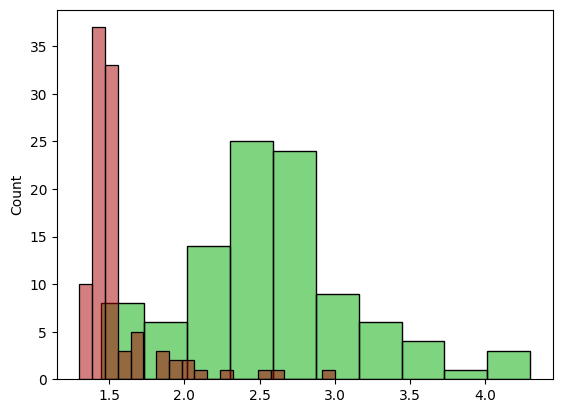

In [28]:
f, ax = plt.subplots(1, 1)
sns.histplot(log_ratio_positive, ax=ax, legend="Positive", color="#00AA00", alpha=0.5)
sns.histplot(log_ratio_negative, ax=ax, legend="Positive", color="#AA0000", alpha=0.5)